# Table of Contents

- [Introduction](#1)
- [Opening the data files and studying the general information](#2)
- [Preparing the data for analysis](#3)
- [Task 1) Finding the Top 10 Neighborhoods for Taxi Dropoffs](#4)
- [Task 2) Comparing the Popularity of Different Taxi Companies](#5)
- [Task 3) Duration of Rides In Different Weather Conditions Hypothesis Test](#6)
- [Conclusions](#7)

# Introduction <a id=1></a>

I am an analyst for **Zuber**, a new ride-sharing company that is launching in Chicago. 

I have been hired to complete the following tasks:

1) Identify the top 10 neighborhoods in Chicago in terms of number of dropoffs. 

2) Determine how taxi companies (in Chicago) rank in terms of number of rides given.

3) Test this hypothesis: ***The average duration of rides from the Loop (neighborhood) to O'Hare International Airport changes on rainy Saturdays.***

In order to complete these tasks, I use three data files that were previously acquired using SQL. The contents of the files are as follows:

**project_sql_result_01.csv**

— company_name (The name of the taxi company)

— trips_amount (The number of rides completed by the drivers of the corresponding taxi company on November 15-16, 2017)

**project_sql_result_04.csv**

— dropoff_location_name (The name of a Chicago neighborhood where a non-zero number of taxi rides ended)

— average_trips (The average number of rides that ended in the corresponding neighborhood in November 2017)

**project_sql_result_07.csv**

— start_ts (A taxi ride's pickup date and time, where time is rounded to the hour)

— weather_conditions (The weather conditions at the moment the corresponding taxi ride started, written as simply "Good" or "Bad")

— duration_seconds (The corresponding taxi ride's duration in seconds)

After completing the above tasks, I write out my insights which **Zuber** stakeholders may use to make decisions regarding how to successfully launch.

In [1]:
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Opening the data files and studying the general information <a id=2></a>

In [2]:
nov_15_to_16_2017_trips_data_of_companies = pd.read_csv('/datasets/project_sql_result_01.csv')

nov_15_to_16_2017_trips_data_of_companies.info()

display(nov_15_to_16_2017_trips_data_of_companies)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3


It is good to see that both column names are written in snake_case, and that both columns only have non-null values. 

Furthermore, it makes sense for **company_name** to have Dtype "object" since one would expect company names to be written as strings, and it also makes sense for **trips_amount** to have Dtype "int64" as opposed to float because taxi trips are discrete quantities. (It would not make sense for a **trips_amount** value to be, for example, 10.5 because one cannot take 0.5 of a taxi ride).

Furthermore, it appears that the rows are arranged in descending order of **trips_amount** values. How convenient!

In [3]:
avg_trips_of_neighborhoods = pd.read_csv('/datasets/project_sql_result_04.csv')

avg_trips_of_neighborhoods.info()

display(avg_trips_of_neighborhoods)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


Just like the first dataframe, both column names are written in snake_case and only have non-null values.

Also just like the first dataframe, the Dtypes are appropriate. It makes sense for the **average_trips** values to have Dtype "float64" because when taking the average of discrete values, in this case number of taxi rides, it is common for the resulting average to be a decimal. In some situations it would make sense to round the values, however I will not do that here because rounding the values in a dataframe upfront can lead to calculation errors later on in the analysis.

Sure enough, the rows appear to be arranged in descending order of **average_trips** values. Fantastic!

In [4]:
trips_loop_to_ohare_by_weather = pd.read_csv('/datasets/project_sql_result_07.csv')

trips_loop_to_ohare_by_weather.info()

display(trips_loop_to_ohare_by_weather)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


I think it is worth explaining that the **weather_conditions** data was parsed from a website on weather in Chicago in November 2017 using SQL. Afterwards, each hour of every day in November was put into one of two groups: "Bad" if the description field from the parsed data contained the words "rain" and/or "storm", and "Good" for all others.

Just like the other two dataframes, it is good to see that the column names are written in snake_case and that there are no null values. However, I have two ideas on how to better prepare this dataframe for analysis:

(1) The **start_ts** values do not appear to be in any particular order, and I think it would be nice to rearrange them in ascending order so that they are then in chronological order.

(2) By displaying part of the dataframe, I can see that there is at least one **duration_seconds** value of 0.0. This is probably either a typo or it signifies that the ride (for whatever reason) was canceled. Whatever the case, any rows that have a **duration_seconds** value of 0.0 will need to be dropped because they are not useful for this analysis.

# Preparing the data for analysis <a id=3></a>

It is always a good idea to check if any of the dataframes have rows that are exact duplicates, and if so drop them.

In [5]:
display(nov_15_to_16_2017_trips_data_of_companies[nov_15_to_16_2017_trips_data_of_companies.duplicated()])

,company_name,trips_amount


The first dataframe does not have any rows that are exact duplicates. Great!

In [6]:
display(avg_trips_of_neighborhoods[avg_trips_of_neighborhoods.duplicated()])

,dropoff_location_name,average_trips


The second dataframe does not have any rows that are exact duplicates. Wonderful!

In [7]:
display(trips_loop_to_ohare_by_weather[trips_loop_to_ohare_by_weather.duplicated()])

,start_ts,weather_conditions,duration_seconds
62,2017-11-11 06:00:00,Good,1260.0
74,2017-11-11 08:00:00,Good,1380.0
76,2017-11-04 09:00:00,Good,1380.0
117,2017-11-11 07:00:00,Good,1380.0
119,2017-11-04 14:00:00,Good,3300.0
...,...,...,...
1054,2017-11-11 07:00:00,Good,1380.0
1058,2017-11-25 12:00:00,Good,1440.0
1062,2017-11-11 06:00:00,Good,1500.0
1065,2017-11-11 13:00:00,Good,2100.0


Interesting! There are 197 rows in the dataframe that have at least one exact duplicate. Considering that the durations of the rides are measured in exact seconds, it is very unlikely that two or more distinct taxi rides would take place in the same hour and take the ***exact same*** number of seconds to complete. Even if, hypothetically, these distinct rides all had their drop-off location in the same neighborhood, even then it is very unlikely that they would have the same duration due to variables including, but not limited to, which route the taxi driver took, whether the rider needed some time at the end of the ride to take out cash from their wallet/purse to pay the driver or not, and which exact building in the neighborhood the rider got dropped off at.

Hence, I am convinced that all the rows which are exact duplicates of a previous row should be dropped from the dataframe. Granted, it is ***possible*** that some of these apparent duplicates are genuinely distinct taxi rides, but it would be very difficult, if not impossible, to figure out which are distinct and which are not.

In [8]:
trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather.drop_duplicates(keep = 'first').reset_index(drop = True)

trips_loop_to_ohare_by_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            871 non-null    object 
 1   weather_conditions  871 non-null    object 
 2   duration_seconds    871 non-null    float64
dtypes: float64(1), object(2)
memory usage: 20.5+ KB


Out of the 1068 rows in the original dataframe, 871 still remain, which I think is ample data for testing the hypothesis about the average duration of rides from the Loop neighborhood to O'Hare International Airport on rainy Saturdays.

Regarding the first dataframe, I am worried that there might be some implicit duplicates in the form of the same company appearing in two or more rows. 

The code below prints the names of all the companies that appear in the dataframe, one company per line and in alphabetical order.

In [9]:
for company in sorted(nov_15_to_16_2017_trips_data_of_companies['company_name']):
    print(company)

0118 - 42111 Godfrey S. Awir
1085 - 72312 N and W Cab Co
1469 - 64126 Omar Jada
2092 - 61288 Sbeih Company
2192 - 73487 Zeymane Corp
2241 - 44667 - Felman Corp
24 Seven Taxi
2733 - 74600 Benny Jona
2809 - 95474 C & D Cab Co Inc.
2823 - 73307 Lee Express Inc
3011 - 66308 JBL Cab Inc.
303 Taxi
3556 - 36214 RC Andrews Cab
3591 - 63480 Chuks Cab
3620 - 52292 David K. Cab Corp.
3623 - 72222 Arrington Enterprises
3721 - Santamaria Express
4053 - 40193 Adwar H. Nikola
4615 - 83503 Tyrone Henderson
4623 - 27290 Jay Kim
5 Star Taxi
5006 - 39261 Salifu Bawa
5062 - 34841 Sam Mestas
5074 - 54002 Ahzmi Inc
5874 - 73628 Sergey Cab Corp.
5997 - 65283 AW Services Inc.
6057 - 24657 Richard Addo
6574 - Babylon Express Inc.
6742 - 83735 Tasha Ride Inc
6743 - 78771 Luhak Corp
American United
American United Taxi Affiliation
Blue Diamond
Blue Ribbon Taxi Association Inc.
Checker Taxi
Checker Taxi Affiliation
Chicago Carriage Cab Corp
Chicago Independents
Chicago Medallion Leasing INC
Chicago Medallion Mana

Though none of the company names are exactly the same, I noticed there are multiple instances where two companies have close to the same name, one example being that there is **Taxi Affiliation Services** yet also **Taxi Affiliation Service** <u>***Yellow***</u>. At first I considered either somehow merging rows of companies with similar names or dropping one of the two because I suspect that some (if not all) of these companies are actually one in the same, but ultimately I decided to keep all of these company names, partially because I don't want to risk losing or mangling useful data.

There are probably good reasons why there are slight variations in company names that are otherwise very similar, one possible reason being that they are different components of the same company that specialize in different kinds of taxi services. This would make sense because it would be like how Uber is one company, yet when requesting a ride with Uber one can, depending on where they are and where they want to go, request one of several different options including UberX, UberX Saver, Uber Green, Comfort, and Premier SUV.

I wonder if the second dataframe has any implicit duplicates of the kind that I initially suspected the first dataframe might have? Let us check and see if any of the **dropoff_location_name** values are repeated.

In [10]:
for neighborhood in sorted(avg_trips_of_neighborhoods['dropoff_location_name']):
    print(neighborhood)

Albany Park
Andersonville
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Boystown
Bridgeport
Brighton Park
Bucktown
Burnside
Calumet Heights
Chatham
Chicago Lawn
Chinatown
Clearing
Douglas
Dunning
East Side
East Village
Edgewater
Edison Park
Englewood
Fuller Park
Gage Park
Garfield Park
Garfield Ridge
Gold Coast
Grand Boulevard
Grand Crossing
Grant Park
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jackson Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Little Italy, UIC
Little Village
Logan Square
Loop
Lower West Side
Mckinley Park
Montclare
Morgan Park
Mount Greenwood
Museum Campus
Near South Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Old Town
Portage Park
Pullman
River North
Riverdale
Rogers Park
Roseland
Rush & Division
Sauganash,Forest Glen
Sheffield & DePaul
South Chicago
South Deering
South Shore
Streeterville
Ukrainian Village
Undef
United Center
Uptown
Washin

All of the above neighborhood names are distinct, and hence I see no reason to drop any of the rows in the dataframe. Sure, in some instances there are multiple neighborhoods that contain at least one word that is the same (for example, there are six neighborhoods whose name begins with "West"), but this is normal (in my personal experience, I have witnessed "West Main Street" and "West Boulevard" be common names for locations in a city). 

In the **Opening the data files and studying the general information** section of this project, I mentioned that it would be nice if the rows in the third dataframe were arranged in ascending order of **start_ts** values. The following code does exactly this.

In [11]:
trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather.sort_values(by = 'start_ts')

In the **Opening the data files and studying the general information** section, I also mentioned that it is a good idea to drop all the rows that have a **duration_seconds** value of 0.0, as these are probably either typos or canceled rides.

In [12]:
trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather[trips_loop_to_ohare_by_weather['duration_seconds'] > 0]

trips_loop_to_ohare_by_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 743 to 566
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            865 non-null    object 
 1   weather_conditions  865 non-null    object 
 2   duration_seconds    865 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.0+ KB


Since there were 871 rows in this dataframe earlier (after I dropped the duplicate rows) and now there are 865, that means there were 6 rows with a **duration_seconds** value of 0.0. This decrease in the number of rows is insignificant.

Come to think of it, I wonder if there are any non-zero **duration_seconds** values that don't make sense in this context, and hence their corresponding rows should be dropped. Using Google Maps, I realized that the Loop and O'Hare are, under normal circumstances, at least 30 minutes apart from one another. In fact, certain locations in the Loop are more like 40 minutes away from the airport, possibly more. 

I can imagine there being taxi rides that manage to get to O'Hare from the Loop in only 25 minutes (e.g. the rider has an early morning flight, and hence takes a taxi while there are little to no other cars on the road), but anything under 25 minutes sounds extremely unrealistic. Since 25 minutes is the same as 1500 seconds, then any **duration_seconds** values under 1500.0 should be dropped from the dataframe because these values are probably either typos or signify incomplete taxi rides.

In [13]:
trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather[trips_loop_to_ohare_by_weather['duration_seconds'] >= 1500]

trips_loop_to_ohare_by_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 743 to 566
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            624 non-null    object 
 1   weather_conditions  624 non-null    object 
 2   duration_seconds    624 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.5+ KB


There are now 241 fewer rows. It is unfortunate that so many rows had such unrealistic **duration_seconds** values, but quality is more important than quantity!

I suspect that the third dataframe has **duration_seconds** values that are high outliers, but I need to use a more robust method to know for sure. A common method for identifying outliers consists of using the IQR (interquartile range) value. The code below tells me the first and third quartile values, which will help me calculate the IQR value, thereby allowing me to figure out if there are any more outliers. 

In [14]:
trips_loop_to_ohare_by_weather['duration_seconds'].describe()

count     624.000000
mean     2418.724359
std       678.868628
min      1500.000000
25%      1913.500000
50%      2333.000000
75%      2820.000000
max      7440.000000
Name: duration_seconds, dtype: float64

In [15]:
q1_duration = trips_loop_to_ohare_by_weather['duration_seconds'].quantile(0.25)
q3_duration = trips_loop_to_ohare_by_weather['duration_seconds'].quantile(0.75)

iqr_duration = q3_duration - q1_duration
low_outlier_duration = q1_duration - 1.5*(iqr_duration)
high_outlier_duration = q3_duration + 1.5*(iqr_duration)

print(
f'A duration_seconds value is an outlier if it is less than {low_outlier_duration} or more than {high_outlier_duration}')

A duration_seconds value is an outlier if it is less than 553.75 or more than 4179.75


There are no more low outliers since the minimum duration is now 1500.0 seconds, but there is at least one high outlier because the describe() function revealed to me that the maximum duration_seconds value is 7440.0, which is much more than 4179.75. 

The code below filters the dataframe to include only the rows where the **duration_seconds** value is at most 4179.75, as well as resets the index because I am now finished with dropping rows. 

In [16]:
trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather[trips_loop_to_ohare_by_weather['duration_seconds']<=4179.75]

trips_loop_to_ohare_by_weather = trips_loop_to_ohare_by_weather.reset_index(drop = True)

trips_loop_to_ohare_by_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            618 non-null    object 
 1   weather_conditions  618 non-null    object 
 2   duration_seconds    618 non-null    float64
dtypes: float64(1), object(2)
memory usage: 14.6+ KB


There were 6 rows with high outlier **duration_seconds** values, and the dataframe now has 618 rows. 

This dataframe originally had 1068 rows, meaning approximately 42% of the initial rows have been dropped. I do not see this as a bad thing though, since 58% is still the majority of the initial dataset, and I am convinced that the dataset is now of much higher quality (and hence will yield more accurate results).

# Task 1) Finding the Top 10 Neighborhoods for Taxi Dropoffs <a id=4></a>

In [17]:
display(avg_trips_of_neighborhoods.head(10))

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


Wow... what a decrease from the neighborhood in first place to the one in tenth place! Loop is the clear winner, followed somewhat distantly by River North in second place, and then there is a ***big*** decrease to third place with Streeterville. There is a somewhat big decrease from third place to fourth place where West Loop stands, and then a big decrease to fifth place where O'Hare stands. From there, the decreases become much less dramatic.

Let's make a bar graph of these top 10 average_trips values!

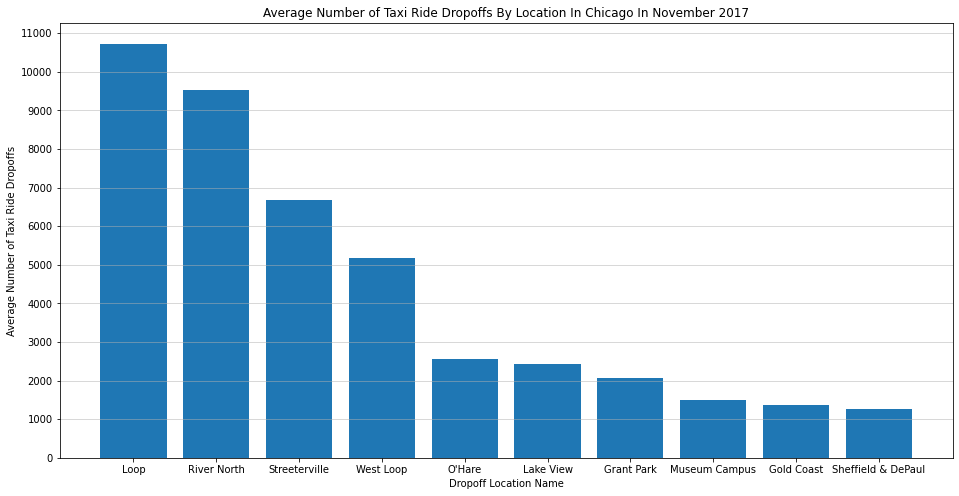

In [18]:
top_10_dropoffs = avg_trips_of_neighborhoods.head(10)

plt.figure(figsize = (16, 8))
plt.bar(top_10_dropoffs['dropoff_location_name'], top_10_dropoffs['average_trips'])
plt.grid(axis = 'y', linestyle = '-', linewidth = 0.7, alpha = 0.7)
plt.title('Average Number of Taxi Ride Dropoffs By Location In Chicago In November 2017')
plt.xlabel('Dropoff Location Name')
plt.ylabel('Average Number of Taxi Ride Dropoffs')
plt.yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000])

plt.show()

The above bar graph nicely visualizes my description from earlier of how from the first place to the fifth place neighborhood the average number of taxi ride dropoffs decreases by a lot as you go in descending order of place, but the decreases in each place from fifth to tenth are much steadier and less dramatic.

I am curious to know which of these dropoff locations, if any, are high outliers in terms of average number of taxi ride dropoffs when compared to the norm. 

I will use the formula Q3 + 1.5*IQR to find the high outliers, where Q3 is the third quartile value and IQR is the interquartile range (Q3 – Q1).

In [19]:
q1_avg_trips = avg_trips_of_neighborhoods['average_trips'].quantile(0.25)
q3_avg_trips = avg_trips_of_neighborhoods['average_trips'].quantile(0.75)

iqr_avg_trips = q3_avg_trips - q1_avg_trips

high_outlier_avg_trips = q3_avg_trips + 1.5*(iqr_avg_trips)

print(f'An average_trips value is a high outlier if it is more than {high_outlier_avg_trips}')

An average_trips value is a high outlier if it is more than 725.7458333333334


Wow! All 10 of the top 10 dropoff locations are high outliers in terms of their average_trips values. I am glad I did this outliers analysis because this should really put into perspective for **Zuber** stakeholders why they should pay especially close attention to these neighborhoods as potential dropoff locations.

I don't see any harm in making a box plot of the average_trips values. In fact, I think a box plot would nicely visualize how extreme the high outliers are.

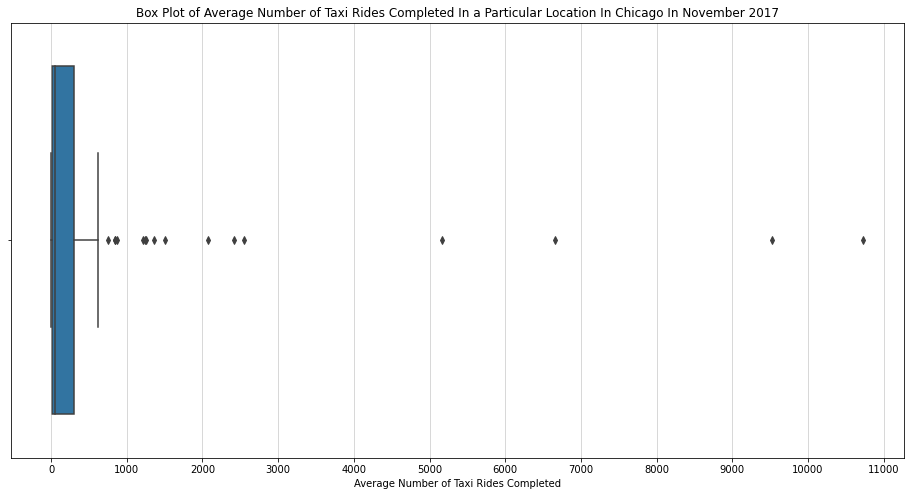

count       94.000000
mean       599.953728
std       1714.591098
min          1.800000
25%         14.266667
50%         52.016667
75%        298.858333
max      10727.466667
Name: average_trips, dtype: float64


In [20]:
plt.figure(figsize = (16, 8))
sns.boxplot(data = avg_trips_of_neighborhoods, orient = 'h', x = 'average_trips')
plt.grid(axis = 'x', linestyle = '-', linewidth = 0.7, alpha = 0.7)
plt.title('Box Plot of Average Number of Taxi Rides Completed In a Particular Location In Chicago In November 2017')
plt.xlabel('Average Number of Taxi Rides Completed')
plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000])
plt.show()

print(avg_trips_of_neighborhoods['average_trips'].describe())

Wow! I especially find it eye-opening how the median **average_trips** value is merely approximately 52. Medians are often used to represent the "typical" value of a dataset, yet in this case the median value is ***tiny*** compared to how large the largest values are. This goes to show that a small number of neighborhoods in Chicago are used as taxi dropoff locations a hugely disproportionately larger number of times than "typical" Chicago neighborhoods. 

# Task 2) Comparing the Popularity of Different Taxi Companies <a id=5></a>

Just like what I did in Task 1), I think it is appropriate to figure out which are the top 10 performing taxi companies, in terms of the number of rides completed by their drivers on November 15-16, 2017.

In [21]:
nov_15_to_16_2017_trips_data_of_companies.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


Now let's make a bar graph! 

Before that, however, I will give some of the above companies an abbreviation because otherwise the names won't fit nicely on the graph.

I will abbreviate... 

— **Taxi Affiliation Services** as TAS

— **Medallion Leasing** as Medallion L.

— **Taxi Affiliation Service Yellow** as TAS Yellow

— **Chicago Carriage Cab Corp** as CCCC

— **Star North Management LLC** as SNM LLC

— **Blue Ribbon Taxi Association Inc.** as BRTA Inc.

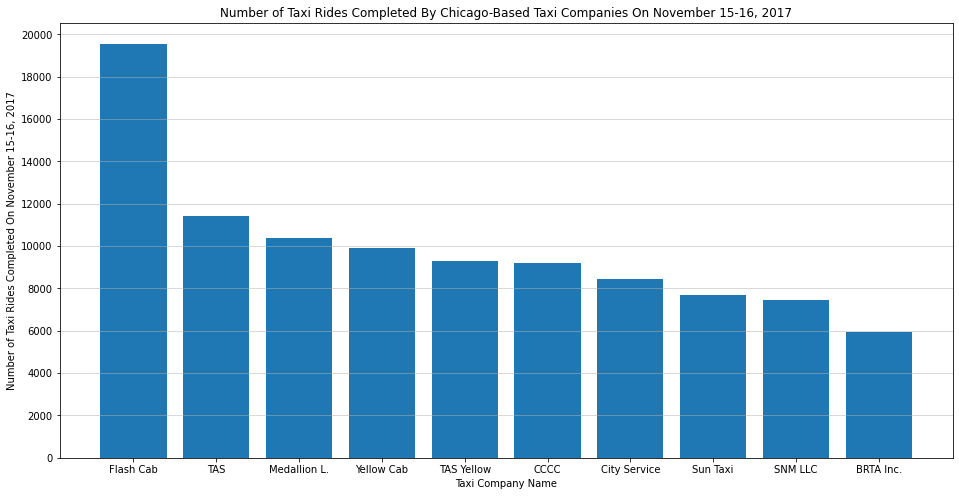

In [22]:
top_10_taxi_companies = nov_15_to_16_2017_trips_data_of_companies.head(10).copy()

top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Taxi Affiliation Services', 'TAS')
top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Medallion Leasing', 'Medallion L.')
top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Taxi Affiliation Service Yellow', 
                                                                                      'TAS Yellow')
top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Chicago Carriage Cab Corp', 'CCCC')
top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Star North Management LLC', 
                                                                                      'SNM LLC')
top_10_taxi_companies['company_name'] = top_10_taxi_companies['company_name'].replace('Blue Ribbon Taxi Association Inc.', 
                                                                                      'BRTA Inc.')

plt.figure(figsize = (16, 8))
plt.bar(top_10_taxi_companies['company_name'], top_10_taxi_companies['trips_amount'])
plt.grid(axis = 'y', linestyle = '-', linewidth = 0.7, alpha = 0.7)
plt.title('Number of Taxi Rides Completed By Chicago-Based Taxi Companies On November 15-16, 2017')
plt.xlabel('Taxi Company Name')
plt.ylabel('Number of Taxi Rides Completed On November 15-16, 2017')
plt.yticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000])

plt.show()

Wow! **Flash Cab** is ***by far*** the most commonly selected taxi company in Chicago! In fact, the number of rides completed by **Flash Cab** drivers on November 15-16, 2017 is somewhat close to double the number of rides completed by the second place company, **Taxi Affiliation Services**. From second place onward, however, the decrease in the number of rides is relatively small and steady, except for a somewhat large decrease from ninth place (Star North Management LLC) to tenth (Blue Ribbon Taxi Association Inc.).

In [23]:
q1_trips_amount = nov_15_to_16_2017_trips_data_of_companies['trips_amount'].quantile(0.25)
q3_trips_amount = nov_15_to_16_2017_trips_data_of_companies['trips_amount'].quantile(0.75)

iqr_trips_amount = q3_trips_amount - q1_trips_amount

low_outlier_trips_amount = q1_trips_amount - 1.5*(iqr_trips_amount)
high_outlier_trips_amount = q3_trips_amount + 1.5*(iqr_trips_amount)

print(f'A trips_amount value is a low outlier if it is less than {low_outlier_trips_amount}')
print(f'A trips_amount value is a high outlier if it is more than {high_outlier_trips_amount}')

A trips_amount value is a low outlier if it is less than -3107.875
A trips_amount value is a high outlier if it is more than 5235.125


Just like what happened in Task 1), I have come to the realization that all 10 of the top 10 most commonly used taxi companies are high outliers in terms of their trips_amount values. This means that even those **Flash Cab** is by far the most popular taxi company in Chicago, **Zuber** would also benefit from partnerships with all 9 of the taxi companies on the top 10 list.

On the flip side, when I displayed the dataframe earlier I noticed that there are multiple companies whose trips_amount values were in the single digits! This is probably because these "companies" are actually merely individuals using their personal car as an occasional taxi. For example, "2733 - 74600 Benny Jona" likely refers to an individual named Benny Jona who uses his own car as a taxi when his schedule allows for it.

I would now like to make a box plot of the **trips_amount** values for the sake of visualizing how extreme the high outliers are compared to the "norm".

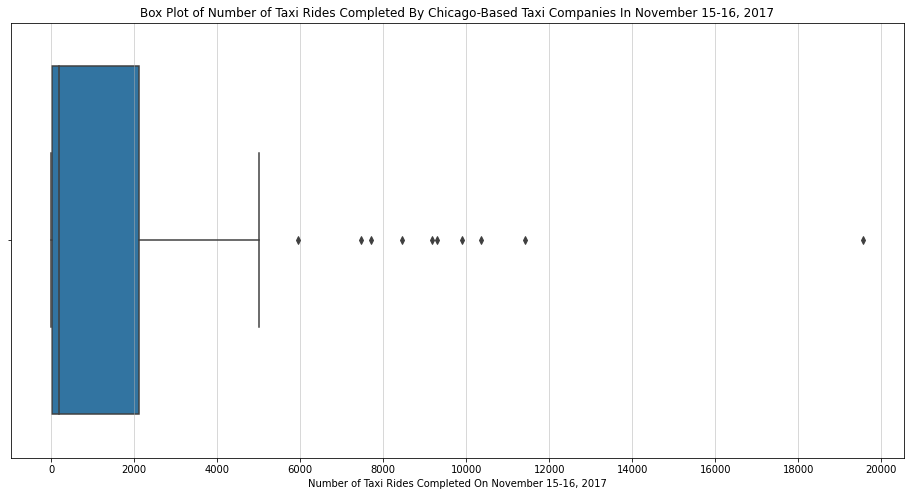

count       64.000000
mean      2145.484375
std       3812.310186
min          2.000000
25%         20.750000
50%        178.500000
75%       2106.500000
max      19558.000000
Name: trips_amount, dtype: float64


In [24]:
plt.figure(figsize = (16, 8))
sns.boxplot(data = nov_15_to_16_2017_trips_data_of_companies, orient = 'h', x = 'trips_amount')
plt.grid(axis = 'x', linestyle = '-', linewidth = 0.7, alpha = 0.7)
plt.title('Box Plot of Number of Taxi Rides Completed By Chicago-Based Taxi Companies In November 15-16, 2017')
plt.xlabel('Number of Taxi Rides Completed On November 15-16, 2017')
plt.xticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000])
plt.show()

print(nov_15_to_16_2017_trips_data_of_companies['trips_amount'].describe())

Similar to my commentary on Task 1)'s box plot, I find it astounding how much smaller the median **trips_amount** value, 178.5, is than the largest **trips_amount** values. This box plot really puts into perspective the extent to which a small number of taxi companies absolutely dominate the market.

# Task 3) Duration of Rides In Different Weather Conditions Hypothesis Test <a id=6></a>

I am interested in testing the following hypothesis:

***The average duration of rides from the Loop (neighborhood) to O'Hare International Airport changes on rainy Saturdays.***

I suspect that this is true. Specifically, I have reason to think that the average duration of rides from the Loop (neighborhood) to O'Hare International Airport is **longer** on rainy Saturdays than on nonrainy Saturdays. Hence, I will used a one-tailed hypothesis test.

When it comes to this kind of testing, the null hypothesis is always the one that supposes the averages are equal, so I define the null and alternative hypotheses in the following way:

**Null:** The average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on rainy Saturdays is equal to the average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on nonrainy Saturdays.

**Alternative:** The average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on rainy Saturdays is ***greater than*** the average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on nonrainy Saturdays.

This test uses a 95% confidence interval, the most commonly used one, because I see no good reason to use a different interval.

I will now create two new dataframes, one containing the Saturday data when the weather was "Good", and the other containing the Saturday data when the weather was "Bad". 

Just before doing that, I create a new dataframe named **sat_rides_nov_2017** that is a filtered version of **trips_loop_to_ohare_by_weather** which only contains the data of rides that took place on a Saturday.

In [25]:
trips_loop_to_ohare_by_weather.loc[:, 'start_ts'] = pd.to_datetime(trips_loop_to_ohare_by_weather.start_ts)

sat_rides_nov_2017 = trips_loop_to_ohare_by_weather[trips_loop_to_ohare_by_weather.start_ts.dt.dayofweek == 5]

In [26]:
nonrainy_sat_rides = sat_rides_nov_2017[sat_rides_nov_2017['weather_conditions'] == 'Good'].reset_index(drop = True)

nonrainy_sat_rides.info()

print()
print('Nonrainy Saturday duration_seconds values summary statistics:')
print(nonrainy_sat_rides['duration_seconds'].describe())
print()
print('Nonrainy Saturday duration_seconds variance value:', nonrainy_sat_rides['duration_seconds'].var())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            495 non-null    datetime64[ns]
 1   weather_conditions  495 non-null    object        
 2   duration_seconds    495 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.7+ KB

Nonrainy Saturday duration_seconds values summary statistics:
count     495.000000
mean     2334.008081
std       597.086191
min      1500.000000
25%      1814.000000
50%      2271.000000
75%      2713.000000
max      4140.000000
Name: duration_seconds, dtype: float64

Nonrainy Saturday duration_seconds variance value: 356511.91896290844


In [27]:
rainy_sat_rides = sat_rides_nov_2017[sat_rides_nov_2017['weather_conditions'] == 'Bad'].reset_index(drop = True)

rainy_sat_rides.info()

print()
print('Rainy Saturday duration_seconds values summary statistics:')
print(rainy_sat_rides['duration_seconds'].describe())
print()
print('Rainy Saturday duration_seconds variance value:', rainy_sat_rides['duration_seconds'].var())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            123 non-null    datetime64[ns]
 1   weather_conditions  123 non-null    object        
 2   duration_seconds    123 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.0+ KB

Rainy Saturday duration_seconds values summary statistics:
count     123.000000
mean     2609.349593
std       566.247730
min      1500.000000
25%      2237.500000
50%      2606.000000
75%      2997.500000
max      4044.000000
Name: duration_seconds, dtype: float64

Rainy Saturday duration_seconds variance value: 320636.4915367186


The dataframe where the weather conditions are "Good" has 495 rows, whereas the dataframe where the weather conditions are "Bad" has 123 rows, which is ***much*** fewer but I suspect that 123 rows of data is still plenty for this hypothesis test.

Interestingly, the two dataframes have quite similar standard deviations values, 597.086191 and 566.247730 respectively, and consequently their variances values are quite similar as well, meaning I will set the **equal_var** parameter to ***True***.

In [28]:
sat_weather_test = st.ttest_ind(nonrainy_sat_rides['duration_seconds'], rainy_sat_rides['duration_seconds'], 
                                equal_var = True)

print('p-value:', sat_weather_test.pvalue)

sat_weather_test_p_value = 0.05

if sat_weather_test.statistic < 0 and sat_weather_test.pvalue < sat_weather_test_p_value / 2:    
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

p-value: 4.600433750349973e-06
We reject the null hypothesis.


Recall that the null hypothesis was defined as "*The average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on rainy Saturdays is equal to the average duration of taxi rides from the Loop neighborhood to O'Hare International Airport on nonrainy Saturdays.*". 

By rejecting this null hypothesis, I am saying that it is far more likely to be true that the average duration of rides from the Loop neighborhood to O'Hare International Airport ***changes*** on rainy Saturdays, specifically that the average duration is ***longer*** on rainy Saturdays than on nonrainy Saturdays.

<u>**SIDE NOTE**</u>**:** 

The if statement requires the **sat_weather_test.statistic** to be less than 0 is because the first sample's mean, **nonrainy_sat_rides['duration_seconds']**, is expected to be less than the second sample's mean, **rainy_sat_rides['duration_seconds']**, and whenever that is true the t–statistic consequently is negative.

# Conclusions <a id=7></a>

If given the opportunity to share my findings with **Zuber** stakeholders, the following are my practical takeaways for them:

(1) According to data from November 2017, there are 10 neighborhoods in Chicago that absolutely dominate with respect to the number of times they are used as taxi dropoff locations, on average. Any neighborhood where the average number of taxi dropoffs is greater than 726 is an outlier, and all 10 of the top 10 neighborhoods match this description. 

The names of the top 10 neighborhoods and their (approximate) average number of taxi dropoffs, in descending order, are as follows:

    1st Loop 10,727
    2nd River North 9,524
    3rd Streeterville 6,665
    4th West Loop 5,164
    5th O'Hare 2,547
    6th Lake View 2,421
    7th Grant Park 2,069
    8th Museum Campus 1,510
    9th Gold Coast 1,364
    10th Sheffield & DePaul 1,260

I recommend **Zuber** to put a lot of focus on advertising their services to noteworthy destinations in these neighborhoods, including hotels, restaurants, and venues. I also recommend **Zuber** to consider occasionally offering deals to customers who use taxis to get to these neighborhoods, perhaps something akin to "If you schedule a taxi ride with **Zuber** at least X hours in advance to one of these neighborhoods, you will get Y% off the price of the ride". 

If 10 neighborhoods is too many to focus on, then **Zuber** should prioritize their advertising efforts on especially (in descending order) the neighborhoods Loop, River North, Streeterville, and West Loop, as there is a big gap in popularity between those 4 and the bottom 6 neighborhoods in the top 10 list.

(2) According to data on the number of rides completed on November 15-16, 2017 by various taxi companies, the top 10 most popular companies absolutely annihilate their lower performing competitors. Any company whose drivers completed over 5,235 rides on those two days is considered an outlier, and all 10 companies on the top 10 list are outliers.  

The names of the top 10 most requested taxi companies and their number of rides completed on November 15-16, 2017, in descending order, are as follows:

    1st Flash Cab 19,558
    2nd Taxi Affiliation Services 11,422
    3rd Medallion Leasing 10,367
    4th Yellow Cab 9,888
    5th Taxi Affiliation Service Yellow 9,299
    6th Chicago Carriage Cab Corp 9,181
    7th City Service 8,448
    8th Sun Taxi 7,701
    9th Star North Management LLC 7,455
    10th Blue Ribbon Taxi Association Inc. 5,953
    
I highly recommend **Zuber** to consider forming partnerships with one or more of the companies in the above top 10 list, the kinds of partnerships where **Zuber** and the other company help each other advertise their services to potential customers. Maybe it would also be a good idea for **Zuber** to occasionally offer deals to customers who use **Zuber** to book a ride with a driver from one of those 10 companies, e.g. "If you use **Zuber** to book a ride with a **Flash Cab** driver, then you will receive a 5 dollar off coupon for use the next time you book with **Zuber**". 

If **Zuber** had to pick only one taxi company to form a partnership with, it should be **Flash Cab** because of how much more popular that company is compared to even the second most popular taxi company, **Taxi Affiliation Services**.

(3) I did a one-tailed hypothesis test to see if there is a statistically significant difference between the average duration of Saturday taxi rides (in seconds) from the Loop neighborhood to O'Hare International Airport when it is raining outside compared to Saturday taxi rides from Loop to O'Hare when it is not raining outside. When I did the test under the assumption that the averages are equal, I ended up rejecting that hypothesis in favor of assuming that the average duration is longer when it is raining than when it isn't.

When considering two taxi rides that are identical except that one is occuring in rainy weather and the other isn't, I think it is reasonable to expect the ride in rainy weather to take longer, on average, because visibility and road conditions are worsened by rain, and consequently taxi drivers and other drivers alike tend to drive slower in such conditions. Hence, **Zuber** should consider paying its drivers more whenever the weather is bad in order to reward them for needing more time to complete drives (on average) and for putting themselves at greater risk of getting into a crash.